# Rain data

## Import libraries

In [7]:
"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

## Load data

- 降水量の合計(mm)
- ~~降水量の合計(mm)現象なし情報~~
- 1時間降水量の最大(mm)
- ~~1時間降水量の最大(mm)現象なし情報~~
- ~~1時間降水量の最大(mm)時分~~
- ~~1時間降水量の最大(mm)時分現象なし情報~~

In [8]:
file_name = "../../data/weather/rain.csv"
df = pl.read_csv(file_name, encoding="shift-jis", skip_rows=3)
display(df.columns)
df.columns = ["date", "day_of_week", "total_precipitation", "total_precipitation_info", "hourly_max_precipitation", \
                "hourly_max_precipitation_info", "hourly_max_precipitation_time", "hourly_max_precipitation_time_info"]
df = df.drop(["hourly_max_precipitation_info", "hourly_max_precipitation_time_info"])
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y/%m/%d")) # convert day column data type into date type
df = df.with_columns(pl.col("hourly_max_precipitation_time").str.strptime(pl.Datetime, "%Y/%m/%d %H:%M")) # convert time column data type into datetime
df.head()

['年月日',
 '曜日',
 '降水量の合計(mm)',
 '降水量の合計(mm)現象なし情報',
 '1時間降水量の最大(mm)',
 '1時間降水量の最大(mm)現象なし情報',
 '1時間降水量の最大(mm)時分',
 '1時間降水量の最大(mm)時分現象なし情報']

date,day_of_week,total_precipitation,total_precipitation_info,hourly_max_precipitation,hourly_max_precipitation_time
date,str,f64,i64,f64,datetime[μs]
2017-07-01,"""土""",11.5,0,4.0,2017-07-01 12:10:00
2017-07-02,"""日""",34.0,0,14.0,2017-07-02 23:26:00
2017-07-03,"""月""",52.0,0,10.0,2017-07-03 09:31:00
2017-07-04,"""火""",37.0,0,11.0,2017-07-04 05:01:00
2017-07-05,"""水""",0.0,0,0.0,2017-07-05 04:46:00


## Check nulls

In [9]:
display(df.null_count())

nulls = df.hstack(df.transpose().select(pl.all().is_null().sum()).transpose().rename({"column_0": "null_count"}))
nulls.filter(pl.col("null_count") != 0)

date,day_of_week,total_precipitation,total_precipitation_info,hourly_max_precipitation,hourly_max_precipitation_time
u32,u32,u32,u32,u32,u32
0,0,6,2,6,6


date,day_of_week,total_precipitation,total_precipitation_info,hourly_max_precipitation,hourly_max_precipitation_time,null_count
date,str,f64,i64,f64,datetime[μs],u32
2019-10-15,"""火""",null,1,null,null,3
2020-06-02,"""火""",null,0,null,null,3
2020-06-03,"""水""",null,null,null,null,4
2020-06-04,"""木""",null,null,null,null,4
2020-06-05,"""金""",null,1,null,null,3
2022-10-02,"""日""",null,1,null,null,3


## Visualization

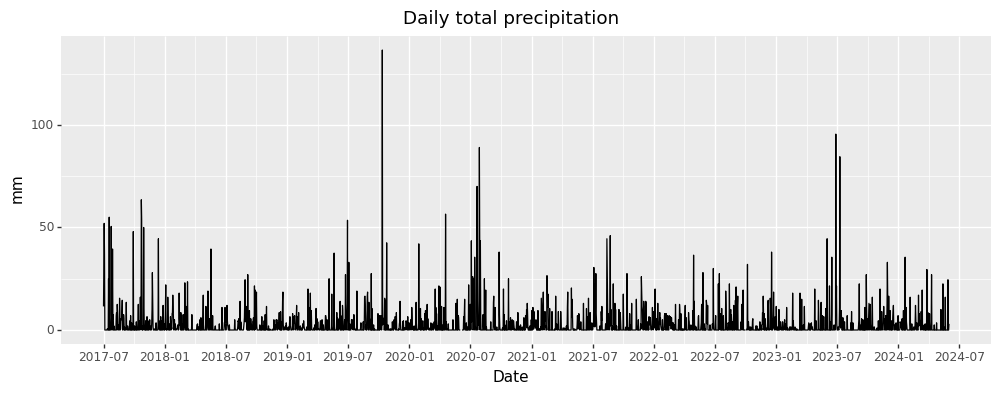

<ggplot: (8791254738806)>

In [10]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="total_precipitation"))
    + labs(title="Daily total precipitation", x="Date", y="mm")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

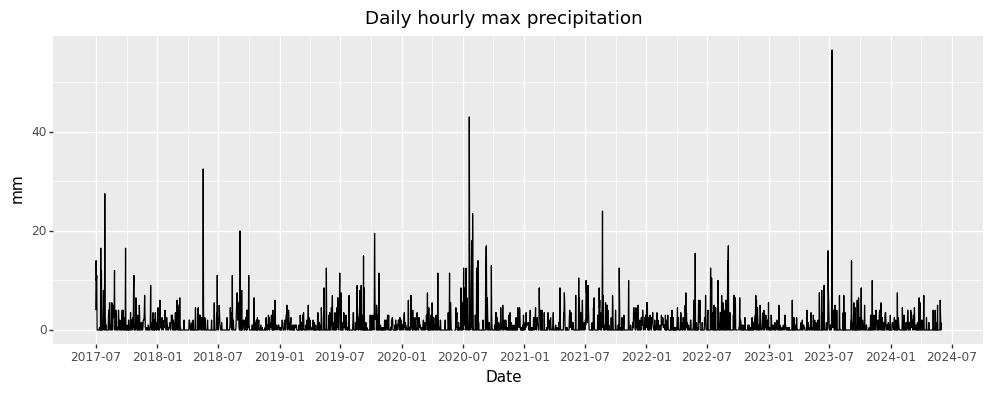

<ggplot: (8791201874593)>

In [11]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="hourly_max_precipitation"))
    + labs(title="Daily hourly max precipitation", x="Date", y="mm")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

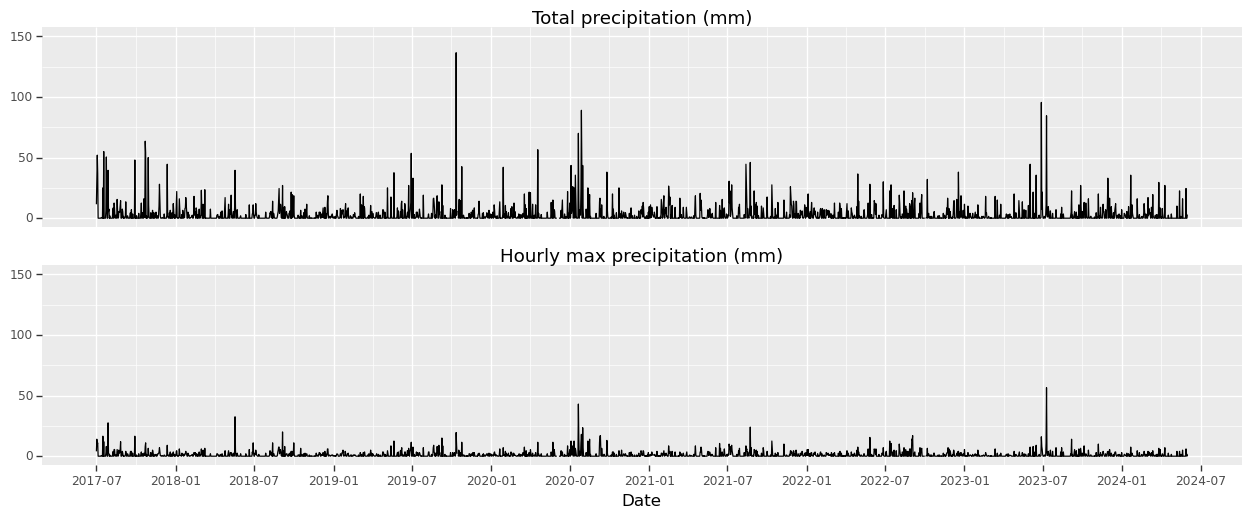

In [12]:
# https://github.com/has2k1/plotnine/issues/46
import patchworklib as pw


g1 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="total_precipitation"))
    + labs(title="Total precipitation (mm)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(0, 150)
)

g2 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="hourly_max_precipitation"))
    + labs(title="Hourly max precipitation (mm)", x="Date", y="")
    + theme(figure_size=(12, 2))
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(0, 150)
)

# By specifying g3 in (g3|g2), g1 is positioned exactly on g3.
pw.param["margin"] = 0.2
(
    g1 / g2
).savefig(fname="../../fig/weather/rain.png", dpi=500)